# Simulations with demo network

This notebook demonstrates the basic work with SBML models based on Antimony, libSBML and RoadRunner. ODE simulations are demonstrated.

In [21]:
%matplotlib inline 
!ls 

Koenig_demo_distributions_01.csv  Koenig demo network.ipynb  Koenig_demo.xml


## SBML with libSBML
Loading model with libsbml and inspect main model features.

In [29]:
import libsbml
doc = libsbml.readSBMLFromFile("Koenig_demo.xml") 
model = doc.getModel()
print model

<Model Koenig_demo "Koenig2014_demo_kinetic_v7">


Print model information like model id, and listOfSpecies

In [30]:
print(model.getId())
print(model.getListOfSpecies())
for s in model.getListOfSpecies():
    print s.getId(), s.getName(), s.getUnits()

Koenig_demo
<ListOfSpecies[6]>
A_in A inside mole
B_in B inside mole
C_in C inside mole
A_out A outside mole
B_out B outside mole
C_out C outside mole


## Antimony

Loading SBML with Antimony and get human readable representation of the information.

In [26]:
import libantimony
libantimony.loadSBMLFile('Koenig_demo.xml')
mod_names = libantimony.getModuleNames()
print mod_names
ant_string = libantimony.getAntimonyString('Koenig_demo')
print(ant_string)

('__main', 'Koenig_demo')
//Created by libAntimony v2.7.0
model *Koenig_demo()

  // Compartments and Species:
  compartment outside, inside;
  species A_in in inside, B_in in inside, C_in in inside, A_out in inside;
  species B_out in inside, C_out in inside;

  // Reactions:
  b1: A_out => A_in; (scale_f*(Vmax_b1/Km_A)*(A_out - A_in))/(1 + A_out/Km_A + A_in/Km_A);
  b2: B_in => B_out; (scale_f*(Vmax_b2/Km_B)*(B_in - B_out))/(1 + B_out/Km_B + B_in/Km_B);
  b3: C_in => C_out; (scale_f*(Vmax_b3/Km_C)*(C_in - C_out))/(1 + C_out/Km_C + C_in/Km_C);
  v1: A_in -> B_in; (scale_f*Vmax_v1)/Km_A*(A_in - 1/Keq_v1*B_in);
  v2: A_in -> C_in; (scale_f*Vmax_v2)/Km_A*A_in;
  v3: C_in -> A_in; (scale_f*Vmax_v3)/Km_A*C_in;
  v4: C_in -> B_in; (scale_f*Vmax_v4)/Km_A*(C_in - 1/Keq_v4*B_in);

  // Species initializations:
  A_in = 0;
  A_in has mM;
  B_in = 0;
  B_in has mM;
  C_in = 0;
  C_in has mM;
  A_out = 10;
  A_out has mM;
  B_out = 0;
  B_out has mM;
  C_out = 0;
  C_out has mM;

  // Compartment

## RoadRunner simulations

Example simulations with the demo network.
First import roadrunner for simulations.
TODO: provide proper packages for imports of the individual components.

In [31]:
import roadrunner
roadrunner.getVersionStr()

'1.3; Compiler: gcc 4.6.3, C++ version: 1; JIT Compiler: LLVM-3.4; Date: Jan 12 2015, 16:43:38'

Loading the model and performing a simple time course simulation.

['time', '[A_in]', '[B_in]', '[C_in]', '[A_out]', '[B_out]', '[C_out]']


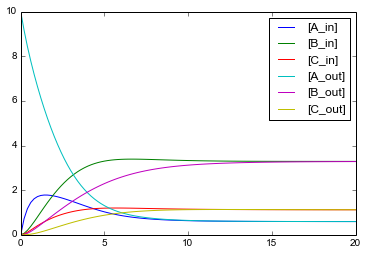

In [33]:
%matplotlib inline
rr = roadrunner.RoadRunner('Koenig_demo.xml')
print rr.selections
s = rr.simulate(0,20, 100, plot=True)  # equidistant timecourse for 20 [s]

The simulation objects is in the state of the end point of the simulation. One can query the steady state values via simple dot syntax.

In [34]:
print('A_in = {}'.format(rr.A_in))
print('Vmax_b1 = {}'.format(rr.Vmax_b1))

A_in = 0.593165574596
Vmax_b1 = 5.0


The units can be read out from the SBML file.

In [35]:
print model
print type(model)

<Model Koenig_demo "Koenig2014_demo_kinetic_v7">
<class 'libsbml.Model'>


In [36]:
s = model.getSpecies('A_in')
print s, s.getId(), s.getName()
print s.getUnits()   # has mole as unit due to substance units
print s.has_only_substance_units

print s.toSBML()

udef =  s.getDerivedUnitDefinition()
libsbml.UnitDefinition_printUnits(udef)

<Species A_in "A inside"> A_in A inside
mole
False
<species id="A_in" name="A inside" compartment="inside" initialConcentration="0" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>


'mole (exponent = 1, multiplier = 1, scale = 0), metre (exponent = -3, multiplier = 1, scale = 0)'

## Steady States

Proper simulation to steady state (i.e. with NEQ solvers and not just based on letting the simulation run for long).

In [37]:
# ? what does the value for time mean here ? 
# bug in the setup
print rr.selections
print rr.getSteadyStateValues()

['time', '[A_in]', '[B_in]', '[C_in]', '[A_out]', '[B_out]', '[C_out]']
[ 0.59626946  3.31260812  1.12628676  0.59626926  3.31256046  1.12628659]


## Stoichiometric Matrix

Access to the stoichiometric matrix of the system is simple via

In [38]:
rr.getFullStoichiometryMatrix()

         b1, b2, b3, v1, v2, v3, v4
A_in  [[  1,  0,  0, -1, -1,  1,  0],
B_in   [  0, -1,  0,  1,  0,  0,  1],
C_in   [  0,  0, -1,  0,  1, -1, -1],
A_out  [ -1,  0,  0,  0,  0,  0,  0],
B_out  [  0,  1,  0,  0,  0,  0,  0],
C_out  [  0,  0,  1,  0,  0,  0,  0]]

In [39]:
rr.getConservationMatrix()

 [[ 1, 1, 1, 1, 1, 1]]

## Jacobian Matrix

Access to Jacobian matrix of the systems via

In [40]:
rr.getFullJacobian()

                 A_in,         B_in,         C_in,        A_out,        B_out,        C_out
A_in  [[ -3.78046e-06,        1e-07,        5e-07,  2.28046e-06,            0,            0],
B_in   [        1e-06, -6.30693e-07,        5e-07,            0,  2.80697e-07,            0],
C_in   [        5e-07,      2.5e-07, -1.38077e-06,            0,            0,  3.80766e-07],
A_out  [  2.28046e-06,            0,            0, -2.28046e-06,            0,            0],
B_out  [            0,  2.80693e-07,            0,            0, -2.80697e-07,            0],
C_out  [            0,            0,  3.80766e-07,            0,            0, -3.80766e-07]]

## Metabolic Control Analysis

Direct access to metabolic control analysis, for instance the Concentration control coefficients.

In [41]:
rr.getScaledConcentrationControlCoefficientMatrix()

 [[   2.5218e-09, -1.49767e-10, -8.18498e-11,  -0.292398,  -0.223684,  0.422515,  0.0935673],
  [   2.5218e-09, -1.49767e-10, -8.18498e-11,  0.0631579, -0.0236842, 0.0447368, -0.0842105],
  [   2.5218e-09, -1.49767e-10, -8.18498e-11, -0.0309598,    0.18808, -0.355263,   0.198142],
  [ -4.00686e-08, -1.49767e-10, -8.18498e-11,  -0.292398,  -0.223684,  0.422515,  0.0935672],
  [   2.5218e-09,  3.05524e-10, -8.18498e-11,  0.0631579, -0.0236842, 0.0447368, -0.0842105],
  [   2.5218e-09, -1.49767e-10,  6.49984e-10, -0.0309598,    0.18808, -0.355263,   0.198142]]

## Repeated simulations

Parameter scan or multiple simulations.
Direct storage of simulation results in a list of numpy arrays.

In [43]:
rr.Vmax_b1 # current value of Vmax_b1

5.0

In [46]:
# kinetic eqution of reaction b1
rids = [r.getId() for r in model.getListOfReactions()]
print rids
r_b1 = model.getReaction('b1')

['b1', 'b2', 'b3', 'v1', 'v2', 'v3', 'v4']


In [51]:
klaw_b1 = r_b1.getKineticLaw()
print 'b1 = {}'.format(klaw_b1.formula)

b1 = scale_f * (Vmax_b1 / Km_A) * (A_out - A_in) / (1 + A_out / Km_A + A_in / Km_A)


-0.10972926831


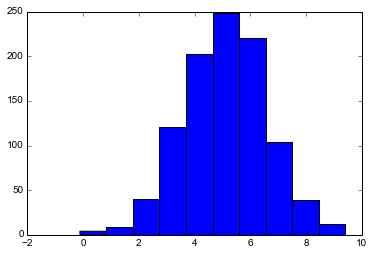

In [104]:
reload(rt)
??rt.simulation
??np.random.normal
# plt.hist(Vmax_test)
# print min(Vmax_test)

time : 0.242800951004 [s]


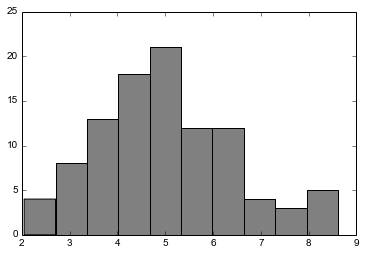

In [111]:
import odesim.roadrunner.roadrunner_tools as rt
import numpy as np
import time

# Create some parameter sampling
# Vmax_test = np.linspace(start=0, stop=10, num=20)
Vmax_test = np.random.normal(loc=5.0, scale=1.5, size=100)
Vmax_test = np.maximum(0.0, Vmax_test)

t1 = time.time()
results = []
for Vmax in Vmax_test:
    # create a parameter dict for the simulation
    parameters = {'Vmax_b1': Vmax}
    inits = {}
    (s, _) = rt.simulation(rr, parameters, inits, t_start=0, t_stop=20, absTol=1e-08, relTol=1e-08, info=False)
    results.append(s)
plt.hist(Vmax_test, color='grey')
print 'time : {} [s]'.format(time.time() - t1)

Use matplotlib to plot the resulting curves.

In [112]:
# print r_b1.toSBML()

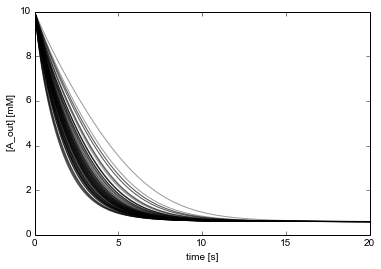

In [113]:
import matplotlib.pyplot as plt
for s in results:
    # plt.plot(results[0].transpose())
    plt.plot(s['time'], s['[A_out]'], color='black', alpha=0.4)
    plt.xlim(0, 20)
    plt.xlabel('time [s]')
    plt.ylabel('[A_out] [mM]')

### Repeated simulations with database backend

For large scale simulations the data has to be stored efficiently in files (HDF5).

In [10]:
import django
django.setup()

In [14]:
import odesim

In [16]:
ls

Koenig_demo_distributions_01.csv  Koenig demo network.ipynb  Koenig_demo.xml


In [18]:
model = django_model_from_file('Koenig_demo.xml', sync=False)

('/home/mkoenig/multiscale-galactose/python/simulator/examples/demo', 'Koenig_demo.xml')
Django model already exists! - model is not saved
